In [2]:
using LinearAlgebra
using Random
using Plots
using Colors
using ImageView
using CSV
using DataFrames

In [6]:
#using Pkg
#Pkg.add("Dates")

In [7]:
#Pkg.add("DataFrames")
#Pkg.add("ImageView")

In [3]:
function OMP(b, A, sparsity_level, bool=true)
    # Orthogonal Matching Pursuit algorithm
    #Input : 
    # b vector to be compressed of size m*1
    # A : dictionary size m*N with m < N
    # sparsity level : number of non zeros coeeficients in the output vector
    # Output : 
    # sparse vector of size N*1
    res = copy(b)
    support = []
    x_s = 0
    for i = 1:sparsity_level
        
        support = OMP1(A, res , support)
        res, x_s = OMP2(A, b, support, bool)
    end
    x = zeros(size(A)[2])
    x[support] = x_s
    return x
    
end

        
        
    

OMP (generic function with 2 methods)

In [4]:
function OMP2(A, b, support, bool)
    # Input
    # A, b : same as above
    # support : indices of non-zeros coefficient
    # Output : 
    # x_s : vectors which minimizes the reconstruction error using only basis vectors in support
    # res : residual ie difference between the vector to be compressed and the reconstructed vector
    # using only basis vectors in support
    A_s = A[:, support]
    if bool
        x_s = cholesky(A_s'*A_s) \ (A_s'*b)
    else
        x_s = inv(A_s'*A_s) * A_s'*b
    end
    res = b - A_s*x_s
    return res, x_s
end

OMP2 (generic function with 1 method)

In [5]:
function OMP1(A, r, support)
    # Input A, support same as above
    # r : residual
    # add a new vector index to the support. It adds the vector which maximises the normalized dot
    # product between it and the residual. 
    # returns the new support
    max_val = -10^7
    n_max = 0
    for n in 1:size(A)[2]
        if !(n in support)
            an = A[:, n]
            val = an'*r/norm(an)^2
            if val > max_val
                max_val = val
                n_max = n
            end
        end
    end
    support = append!(support, n_max)
    return support
end      

OMP1 (generic function with 1 method)

In [11]:
# test the OMP algorithm on one piece of synthetic data
m = 4 # original size
N = 10 # size of sparse vector
s = 3 # sparsity level
A = randn(m,N) # generate a random dictionnary
b = randn(m) # generate randomly the vector that we want to compress
println("original vector")
println(b)
x_hat = OMP(b, A, s) # compressed sparse vector (10 element including 3 non-zeros)
println("compressed sparse vector")
println(x_hat)
println("reconstructed vector")
print(A*x_hat)

original vector
[-0.5696302202579422, 1.261745806100357, -0.03266852834939835, 0.6370162307019116]
compressed sparse vector
[0.0, 0.0, 0.7467243312154935, 0.10769129202978267, 0.0, 0.0, 0.0, 0.7278524395225315, 0.0, 0.0]
reconstructed vector
[-0.5694291288215994, 1.262439603155448, -0.03156741485486059, 0.6358735345342895]

In [13]:
function test_OMP_synthetic_data(m, N, s, nb_tests)
    # returns the mean error between the original data generated randomly following gaussian distribution
    # and the reconstructed vector. ie l1_norm(b-b_hat)
    # also returns the average l1 distance between 2 randomly generated gaussian vector for comparaison
    mean_error = 0
    mean_error_random = 0
    for i in 1:nb_tests
        A = randn(m,N)
        b = randn(m)
        b1 = randn(m)
        x_hat, b_hat, error = compression_reconstruction(b, A, s)
        error_random = sum(abs.(b-b1))/size(b)[1]
        mean_error += error
        mean_error_random += error_random
    end
    return mean_error/nb_tests, mean_error_random/nb_tests
end

     
    

test_OMP_synthetic_data (generic function with 1 method)

In [14]:
test_OMP_synthetic_data(m, N, s, 100)

(0.2286654864972857, 1.1662869198776786)

In [6]:
function generate_sparse_vector(size, s)
    # generate randomly a sparse vector of size s with sparsity level s
    v = zeros(size)
    idxs = shuffle(Vector(1:size))[1:s]
    v[idxs] = randn(s)
    return v
end

generate_sparse_vector (generic function with 1 method)

In [16]:
supp_int_size_avg = 0

for i in 1:100
    x = generate_sparse_vector(N, s)
    y = A*x
    x_hat = OMP(b, A, s)
    supp_int_size = 0
    
    for i in 1:10
        if x_hat[i] != 0
            if x[i] !=0
                supp_int_size = supp_int_size + 1
            end
        end
    end
    supp_int_size_avg += supp_int_size
    
end
           
print("taille moyenne de l'intersection du support", supp_int_size_avg/100)


taille moyenne de l'intersection du support0.96

In [7]:
df = DataFrame(CSV.File("mnist_test.csv")) # load the mnist data base
df=convert(Matrix,df)

10000×785 Array{Int64,2}:
 7  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 2  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 4  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 4  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 9  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 5  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 9  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 6  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 9  0  0  0  0  0  0  0  0  0  0  0  0

In [10]:
dig = df[5, :] # 5 th digits of the data base
dig = dig[2:size(dig)[1]] # we don't care about the label (first element of the vector)

784-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [11]:
function reshape_(dig)
    return transpose(reshape(dig, (28, 28)))
end

#dig_reshaped = reshape_(dig)
#imshow(dig_reshaped)
#Gray.(dig_reshaped/255)

reshape_ (generic function with 1 method)

In [47]:
m = 784 # size of digit (28*28)
N = 2000 # size of sparse vector
A_rd = randn(m,N) # we generate a random dictionnary

784×2000 Array{Float64,2}:
  0.204411   -0.222734   0.972366   …  -0.458543   0.179131   -1.19067
  0.6102     -0.19924    0.81095        0.415593   0.660894    0.115389
  0.193558    1.08313   -0.712204      -0.385769   0.907822   -0.249922
  1.61556     1.2283     2.24299        1.45322   -0.734445   -0.327732
  0.0884018   0.606882  -0.910111      -0.465015  -1.03967    -0.130982
 -1.15411     1.22185   -0.303318   …   0.196333   0.371915   -0.334278
  1.8227     -0.861684   0.0246558      0.405767  -0.755001   -0.994578
 -0.482551    1.60812   -0.776324      -0.529322  -0.286381   -0.246707
 -0.968047   -0.772987  -2.71589       -1.75756    0.741502   -0.778606
  1.35898    -1.20032   -0.530933       2.47332   -0.299932    1.86187
  0.14559    -0.860619  -1.28405    …  -2.04854    0.501917    1.16347
  0.153292    0.522887  -0.583234       0.440127  -0.620609   -0.172351
  0.570532   -0.339985   0.55746        1.15565   -0.705652   -1.51162
  ⋮                                 ⋱    

In [12]:
function compression_reconstruction(b, A, s)
    # compress the input vector b using OMP algorithm. Then reconstruct it with the dictionnary 
    # and compare with the original vector (with a l1 norm). 
    # OUT x_hat : sparse vector representing b
    # b_hat : reconstructed vector using sparse vector x_hat
    # error l1 norm between b_hat and b
    x_hat = OMP(b, A, s, true)
    b_hat = A*x_hat
    error = sum(abs.(b-b_hat))/size(b)[1]
    return x_hat, b_hat, error
end

compression_reconstruction (generic function with 1 method)

In [17]:
# visualize b_hat for one particular example
@time _, recons_digit, _ = compression_reconstruction(dig, A_rd, 100, true)
recons_reshaped = reshape_(recons_digit)
imshow(recons_reshaped)
Gray.(recons_reshaped/255)

LoadError: UndefVarError: compression_reconstruction not defined

In [22]:
function error_wrt_s(A, smin, smax, step)
    # Test the OMP algorithm with different sparsity levels and plot the errr with respect to s
    # IN A : dictionnary
    # smin, smax, step : test value of s between smin and smax separated by step
    s = smin
    ss = []
    errors = []
    
    while s < smax
        println("s=", s)
        _, recons_digit, error = compression_reconstruction(dig, A, s)
        println("error=", error)
        recons_reshaped = reshape(recons_digit, (28, 28))
        err = sum(abs.(recons_digit-dig))/784
        #imshow(recons_reshaped)
        append!(errors, err)
        append!(ss, s)
        #a = Gray.(recons_reshaped/255)
        s = s + step
    end
    plot(ss, errors)
end

error_wrt_s (generic function with 1 method)

s=10
error=36.60317076270604
s=20
error=38.89705607179305
s=30
error=39.877893285194
s=40
error=39.91329603806385
s=50
error=39.59039505048603
s=60
error=39.1579336012233
s=70
error=39.166046526041924
s=80
error=38.40735055130442
s=90
error=37.91117895220428
s=100
error=37.067915103978414
s=110
error=36.58823425598027
s=120
error=36.077311281905736
s=130
error=35.20840174393788
s=140
error=34.58385336571114
s=150
error=33.80852677008009
s=160
error=32.883198981267014
s=170
error=32.0769474724012
s=180
error=31.037742066068468
s=190
error=30.200837185773448
s=200
error=29.426811260294734


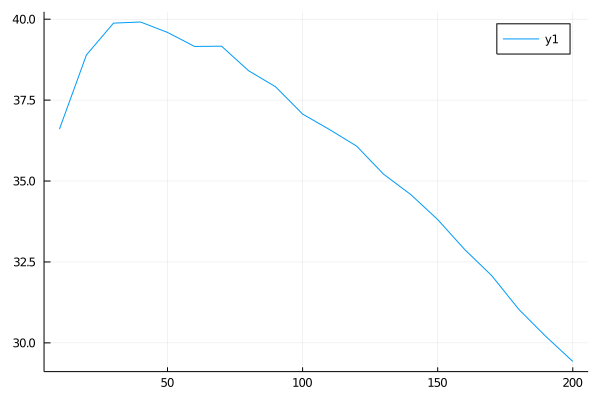

In [23]:
# test different value of s for OMP on random basis
error_wrt_s(A_rd, 10, 210, 10)

We can notice that the error first increases and reach a maximum for s=40, then it decreases more or lesslinearly. It seems not to be a particular case since I observed similar behaviour with other digits. 

The error l1 with s=200 is 30, with a gray color scale between 0 and 255

In [24]:
using ImageView

In [26]:
m = 784
N = 2000
A_cos = cosine_basis(m, N, 10, 200)

784×2000 Array{Float64,2}:
 1.0        0.827081    0.368125    …  -0.218143   0.368125     0.827081
 1.0        0.368125   -0.728969       -0.904827  -0.728969     0.368125
 1.0       -0.218143   -0.904827        0.612907  -0.904827    -0.218143
 1.0       -0.728969    0.0627905       0.637424   0.0627905   -0.728969
 1.0       -0.987688    0.951057       -0.891007   0.951057    -0.987688
 1.0       -0.904827    0.637424    …  -0.24869    0.637424    -0.904827
 1.0       -0.509041   -0.481754        0.999507  -0.481754    -0.509041
 1.0        0.0627905  -0.992115       -0.187381  -0.992115     0.0627905
 1.0        0.612907   -0.24869        -0.917755  -0.24869      0.612907
 1.0        0.951057    0.809017        0.587785   0.809017     0.951057
 1.0        0.960294    0.844328    …   0.661312   0.844328     0.960294
 1.0        0.637424   -0.187381       -0.876307  -0.187381     0.637424
 1.0        0.0941083  -0.982287       -0.278991  -0.982287     0.0941083
 ⋮                    

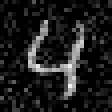

In [55]:
# visualize results on one piece of data with s=150
_, recons_cos, _ = compression_reconstruction(dig, A_cos, 150)
reshaped_cos = reshape_(recons_digit)
Gray.(reshaped_cos/255)

s=10
error=36.60317076270604
s=20
error=38.89705607179305
s=30
error=39.877893285194
s=40
error=39.91329603806385
s=50
error=39.59039505048603
s=60
error=39.1579336012233
s=70
error=39.166046526041924
s=80
error=38.40735055130442
s=90
error=37.91117895220428
s=100
error=37.067915103978414
s=110
error=36.58823425598027
s=120
error=36.077311281905736
s=130
error=35.20840174393788
s=140
error=34.58385336571114
s=150
error=33.80852677008009
s=160
error=32.883198981267014
s=170
error=32.0769474724012
s=180
error=31.037742066068468
s=190
error=30.200837185773448


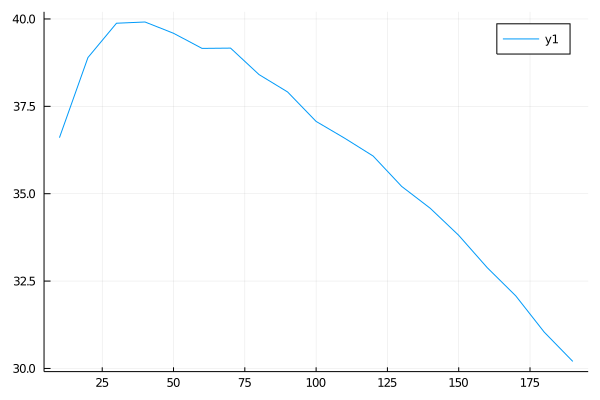

In [28]:
error_wrt_s(A_rd, 10, 200, 10)

Using a cosine basis do not seem to improve the results compared to random

In [95]:
function kSVD(Y, K, s, nb_iter, Y_test=[[]], nb_x_to_update=-1, method=OMP)
    # kSVD alogorithm 
    # Y : d*N array with d the size of one piece of data and N the number of data
    # K : number of atomes in the dictionnary
    # nb_iter : number of iteration of the algorithm
    # Y_test : used for validation 
    # nb_x_to_update : number of data whic are sparse encode in the first step of the algorithm, if equals -1
    # all data are sparse encoded.
    #Methode used for sparse encoding, defaults is OMP. It takes three arguments in this order
    # - the data matrix Y
    #- the dictionnary used to sparse encde
    # - the sparsity level
    # If your method use more than 3 arguments, set the other to default parameters
    # returns the best dictionnary found, the list of train l1 losses at each iteration and the list of valid l1 losses
    d = size(Y)[1]
    N = size(Y)[2]
    N_test = size(Y_test)[2]
    D = randn(d, K)
    best_D = copy(D)
    X = zeros(K, N)
    X_test = zeros(K, N_test)
    best_X = copy(X)
    distances = []
    distances_test = []
    best_distance = 10^15
    if nb_x_to_update == - 1
        nb_x_to_update = N
    end
    for n in 1:nb_iter
        println("itération", n)
        for i in shuffle(Vector(1:N))[1:nb_x_to_update]
            X[:, i] = method(Y[:, i], D, s) #change here 
        end
        for i in 1:N_test
            X_test[:, i] = method(Y_test[:, i], D, s)
        end
        difference = Y - D*X
        difference_test = Y_test - D*X_test
        distance = sum(abs.(difference))/(d*N)
        distance_test = sum(abs.(difference_test))/(d*N_test)
        append!(distances, distance)
        append!(distances_test, distance_test)
        if distance < best_distance
            # If this is the best approximation so far, save everything
            best_distance = distance
            best_D = copy(D)
            best_X = copy(X)
        end
        for k in 1:K
            omega_k = [i for i in 1:N if X[k,i] != 0]
            #omega_k = np.nonzero() # indices of samples with a nonzero k-th entry
            if size(omega_k)[1] != 0 # if the k-th column of D is used
                different_from_k = [1:k; k+1:K]
                E_k = Y - D[:,different_from_k]*X[different_from_k,:] # error without the k-th column of D
                E_k = E_k[:,omega_k]#[:,0,:] # Reduction to the samples that use column k
                U, S, V = svd(E_k) # SVD decomposition
                D[:,k] = U[:,1]' # First column of U
                X[k,omega_k] = S[1]*V[:,1] # First column of V multiplied by the first singular value
            end
        end
    end
    return best_D, distances, distances_test
end
        
            

kSVD (generic function with 4 methods)

In [96]:
function get_first_digits(nb_digits)
    digs = df[1:nb_digits, :] # 5 th digits of the data base
    digs = digs[:, 2:size(digs)[2]]
    return digs'
end
K = 1000
s = 20
nb_iter = 10
N_data = 25
N_train_data = 20
Y = get_first_digits(N_data)
Y_train, Y_test = Y[:, 1:N_train_data], Y[:, N_train_data+1:N_data]
D, distances, distances_test = kSVD(Y_train, K, s, nb_iter, Y_test)
#Gray.(recons_reshaped/255)


    

itération1
itération2
itération3
itération4
itération5
itération6
itération7
itération8
itération9
itération10


([-0.03645010862642379 1.3716211952946078 … -0.226465681189112 -0.1775636132444651; -0.04966248238870437 0.10272077545674727 … -0.9714377807145922 1.2967430356556129; … ; -0.0037931895940898266 -1.7569191471518835 … -0.8723328530004893 -0.5671461027248363; 0.026889738609277174 -1.3063498376186744 … -0.22344014954650193 -0.19854772295473838], Any[44.6900346505154, 18.15628226839245, 18.922175644203264, 18.355933177290634, 18.188112281582697, 16.422690988232397, 15.504725207482853, 18.72309628813401, 16.852442827879916, 17.169417216377738], Any[41.39004022111462, 32.63466731398923, 32.05768175334747, 31.818204902789994, 32.70825265318933, 31.069249801133257, 31.311584020793354, 32.00559306438892, 32.28139700990283, 31.309711904103857])

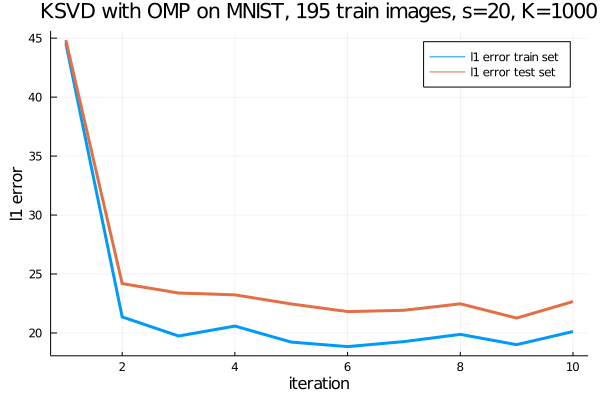

In [60]:
#plot(distances, label="error train set")
#plot!(distances_test, label="error test set")
N_test = N_data - N_train_data
title = "KSVD with OMP on MNIST, $N_train_data train images, s=$s, K=$K"
plot(distances, label="l1 error train set", lw=3)
plot!(distances_test, label="l1 error test set", lw=3)
xlabel!("iteration")
ylabel!("l1 error")
title!(title)


In [68]:
K = 1000
nb_iter = 10
N_data = 25
N_train_data = 20
Y = get_first_digits(N_data)
Y_train, Y_test = Y[:, 1:N_train_data], Y[:, N_train_data+1:N_data]
list_s = [5, 10, 20, 30, 50, 100]
distances_wrt_s = []
for s in list_s
    D, distances, distances_test = kSVD(Y_train, K, s, nb_iter, Y_test)
    append!(distances_wrt_s, distances) 
end

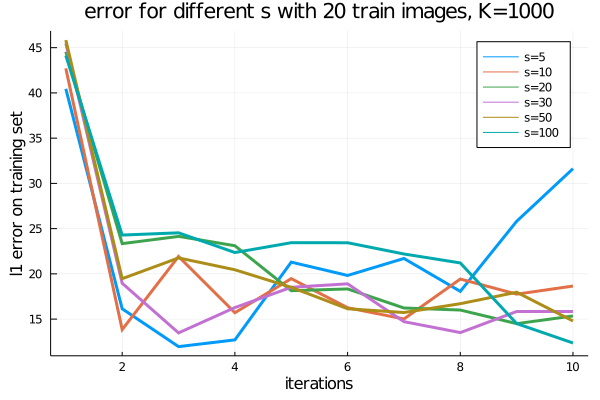

In [80]:
for i in 1:size(list_s)[1]
    distances = distances_wrt_s[nb_iter*(i-1)+1:nb_iter*i]
    s = list_s[i]
    if i==1
       plot(distances, label="s=$s", lw=3)
    else
       plot!(distances, label="s=$s", lw=3) 
    end
end
title!("error for different s with $N_train_data train images, K=$K")
xlabel!("iterations")
ylabel!("l1 error on training set")

In [83]:
nb_iter = 10
N_data = 25
N_train_data = 20
s = 20
Y = get_first_digits(N_data)
Y_train, Y_test = Y[:, 1:N_train_data], Y[:, N_train_data+1:N_data]
list_K = [500, 700, 800, 1000, 1500, 2000]
distances_wrt_K = []
for K in list_K
    print("k=", K)
    D, distances, distances_test = kSVD(Y_train, K, s, nb_iter, Y_test)
    append!(distances_wrt_K, distances) 
end

k=500k=700k=800k=1000k=1500k=2000

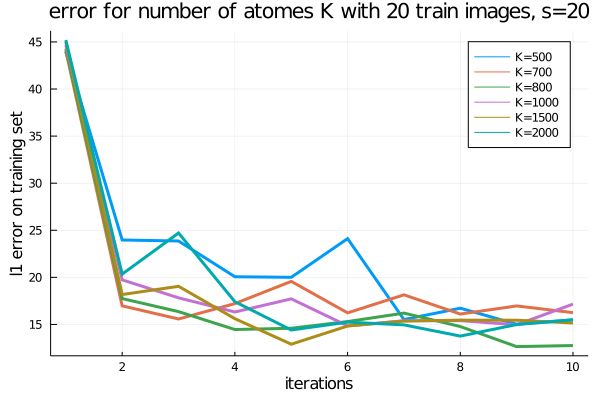

In [84]:
for i in 1:size(list_K)[1]
    distances = distances_wrt_K[nb_iter*(i-1)+1:nb_iter*i]
    K = list_K[i]
    if i==1
       plot(distances, label="K=$K", lw=3)
    else
       plot!(distances, label="K=$K", lw=3) 
    end
end
title!("error for number of atomes K with $N_train_data train images, s=$s")
xlabel!("iterations")
ylabel!("l1 error on training set")

In [88]:
nb_iter = 10
N_data = 65
N_train_data = 60
s = 20
Y = get_first_digits(N_data)
Y_train, Y_test = Y[:, 1:N_train_data], Y[:, N_train_data+1:N_data]
list_nb_x = [0.25, 0.5, 0.75, 1]
K = 1000
distances_wrt_nb_x = []
for nb_x in list_nb_x
    #println("k=", K)
    nb_x_to_update = Int(floor(nb_x*N_train_data))
    D, distances, distances_test = kSVD(Y_train, K, s, nb_iter, Y_test, nb_x_to_update)
    append!(distances_wrt_nb_x, distances) 
end

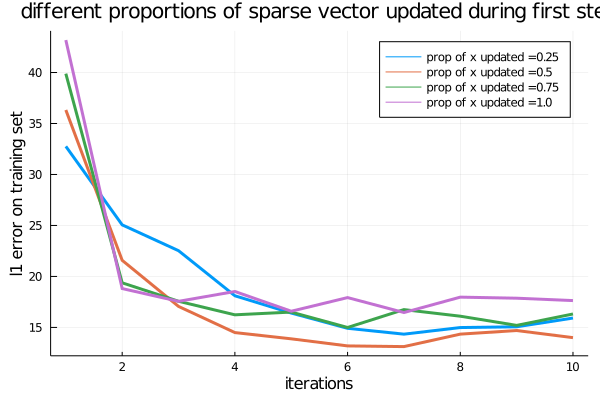

In [90]:
for i in 1:size(list_nb_x)[1]
    distances = distances_wrt_nb_x[nb_iter*(i-1)+1:nb_iter*i]
    nb_x = list_nb_x[i]
    if i==1
       plot(distances, label="prop of x updated =$nb_x", lw=3)
    else
       plot!(distances, label="prop of x updated =$nb_x", lw=3) 
    end
end
title!("different proportions of sparse vector updated during first step")
xlabel!("iterations")
ylabel!("l1 error on training set")

In [87]:
a = 1.3
Int(floor(a))

1

In [33]:
_, recons, _ = compression_reconstruction(Y_test[:, 1], D, s)
recons_reshaped = reshape_(recons)
imshow(recons_reshaped)

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>74: "map(clim-mapped image, input…
  "annotations" => 40: "input-14" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 39: "CLim" = CLim{Float64}(-62.1935, 273.906) CLim{Float64} 

In [37]:
function cosine_basis(m, N, freq_min, freq_max)
    # generate a cosine dictionary : each column is a cosinus function. The frequency increases with the column index
    # freq_min = frequency of first column , freq_max frequency of last column
    A = zeros(m, N)
    f = freq_min
    f_step = (freq_max - freq_min)/N
    for j in 1:N
        for t in 1:m
            A[t, j] = cos(2*pi*f*t)
        end
        f = f + f_step
    end
    return A
end

cosine_basis (generic function with 1 method)

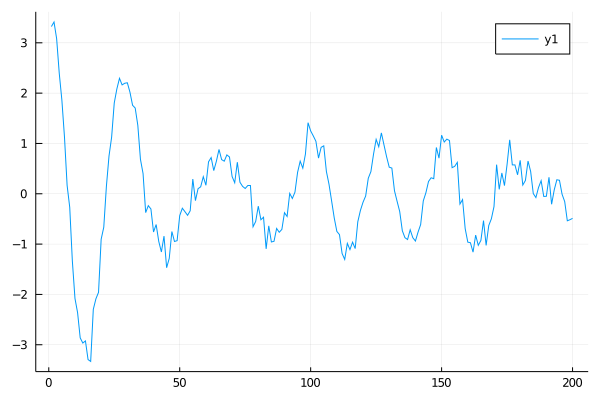

In [65]:
size_original_space = 200
size_sparse_space = 400
freq_min = 5*10^-2
freq_max = 10^-2
s = 5
x = generate_sparse_vector(size_sparse_space, s)
D = cosine_basis(size_original_space, size_sparse_space, freq_min, freq_max)
#print(x)
y = D*x + 0.2*randn(size_original_space)
plot(y)


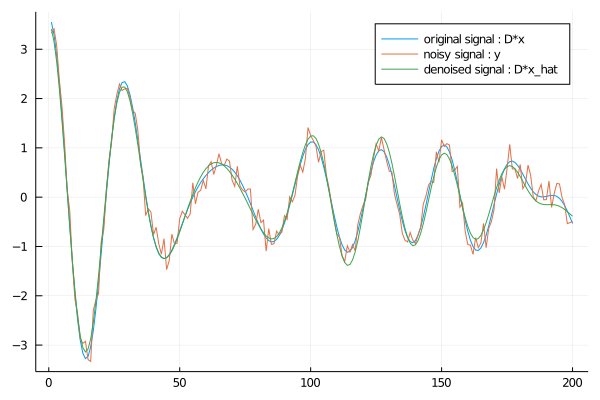

In [77]:
x_hat = OMP(y, D, s, true)
plot(D*x, label="original signal : D*x")
plot!(y, label="noisy signal : y")
plot!(D*x_hat, label="denoised signal : D*x_hat")

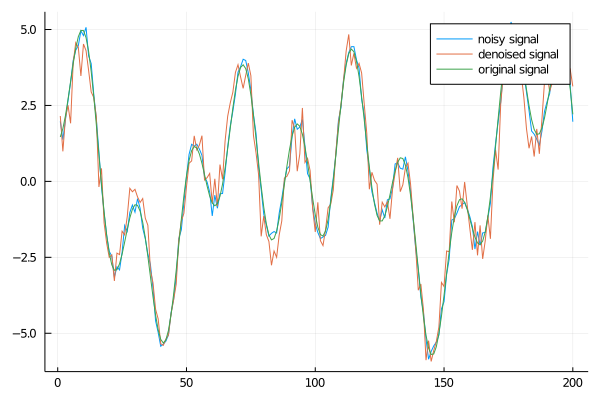

In [87]:
nb_data = 50
X = zeros(size_sparse_space, nb_data)
for i in 1:nb_data
    X[:, i] = generate_sparse_vector(size_sparse_space, s)
end

Y = D*X + 0.2*randn(size_original_space, nb_data)
nb_iter = 10
D_est = kSVD(Y, size_sparse_space, s, nb_iter)

X_hat = zeros(size_sparse_space, nb_data)
for i in 1:nb_data
    X_hat[:, i] = OMP(Y[:, i], D_est, s, true)
end
Y_hat = D_est*X_hat

plot(Y[:, 5], label="noisy signal")
plot!(Y_hat[:, 5], label="denoised signal")
plot!(D*X[:, 5], label="original signal")





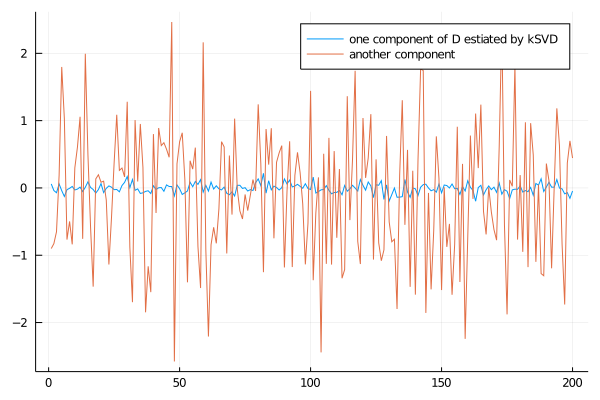

In [83]:
plot(D_est[:, 10], label="one component of D estiated by kSVD")
plot!(D_est[:, 5], label="another component")

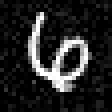

In [106]:
function get_first_digits(nb_digits)
    digs = df[1:nb_digits, :] # 5 th digits of the data base
    digs = digs[:, 2:size(digs)[2]]
    return digs'
end


K = 2000
s = 10
nb_iter = 10
nb_data = 25
nb_train_data = 20
digits = get_first_digits(nb_data)
noisy_digits = digits + 20*randn(784, nb_data)
noisy_digits_train = noisy_digits[:, 1:nb_train_data]
#recons_reshaped = reshape_(recons)
test_digit = 23
Gray.(reshape_(noisy_digits[:, test_digit])/255)

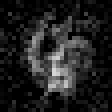

In [107]:
D_est = kSVD(noisy_digits_train, K, s, nb_iter)


x_hat = OMP(noisy_digits[:, test_digit], D_est, s, true)

y_hat = D_est*x_hat
Gray.(reshape_(y_hat/255))





In [74]:
A = [1:2 ;4:5]
println(A)
B = [4 7 8 5 7; 4 1 2 5 1; 1 2 3 4 7]
B[:, A]


[1, 2, 4, 5]


3×4 Array{Int64,2}:
 4  7  5  7
 4  1  5  1
 1  2  4  7

In [105]:
nonzeros([1 0 2 2 0 2 2])

LoadError: UndefVarError: nonzeros not defined